# Genetic algorithm results analysis

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from functools import partial
import os
from itertools import product
import json
import math
import seaborn as sns


In [27]:
import sys

sys.path.append("..")

from functions.utils import *
from functions.crossover import *
from functions.selection_algos import *
from functions.mutations import *
from functions.algorithms import *
from functions.solutions import *
from functions.stats_test import *

In [28]:
df = pd.read_csv("results/ga_results.csv")

> In the end we ran 4800 configurations tests (each configuration ran 30 times) 

In [29]:
len(df)

4800

## Final fitness plots

### Aggregate by mutation, crossover and selection operators

> Aggregating by mutation, crossover and selection we can see that swap mutation is the best performing mutation operator, followed by scramble mutation and inversion mutation last. 
For inversion and scramble mutation, the crossover operator seems to have a significant impact on the performance of the algorithm (partially mapped crossover is better than group preserving order crossover), probably because partially mapped crossover is less disruptive.

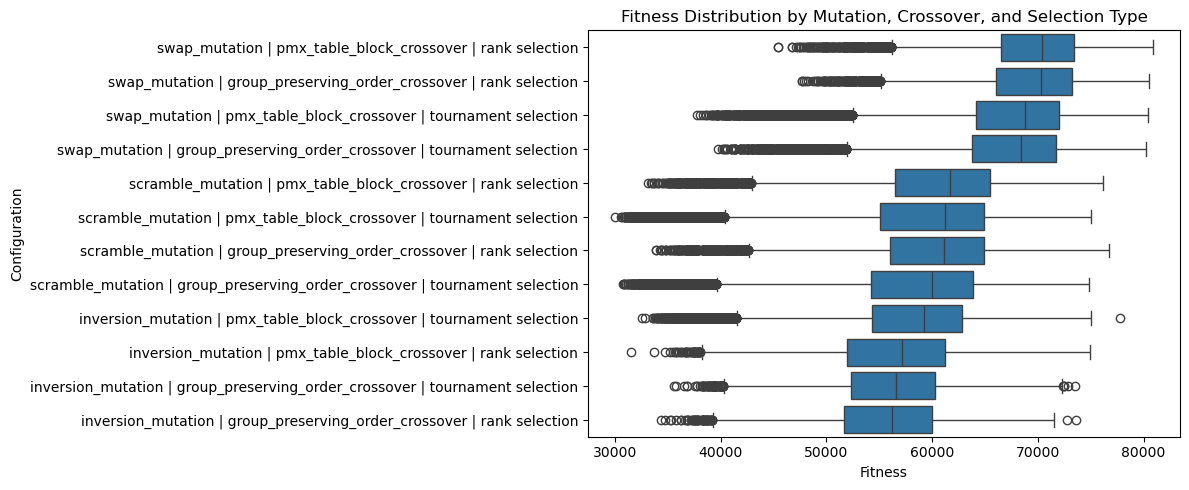

In [30]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    for fitness in fitness_list:
        records.append({
            "mutation": row["mutation"],
            "crossover": row["crossover"],
            "selection": row["selection"],
            "fitness": fitness
        })

df_expanded = pd.DataFrame(records)

df_expanded["config_label"] = (
    df_expanded["mutation"] + " | " +
    df_expanded["crossover"] + " | " +
    df_expanded["selection"] + " selection"
)

median_sorted = (
    df_expanded.groupby("config_label")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

df_expanded["config_label"] = pd.Categorical(df_expanded["config_label"], categories=median_sorted, ordered=True)

plt.figure(figsize=(12, max(5, 0.4 * len(median_sorted))))
sns.boxplot(data=df_expanded, y="config_label", x="fitness", orient="h")
plt.title("Fitness Distribution by Mutation, Crossover, and Selection Type")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()

### Aggregate by mutation operator

> Aggregating only by the mutation operator confirms that swap mutation is the best performing mutation probably due to the fact that it is less disruptive than the other two mutation operators.

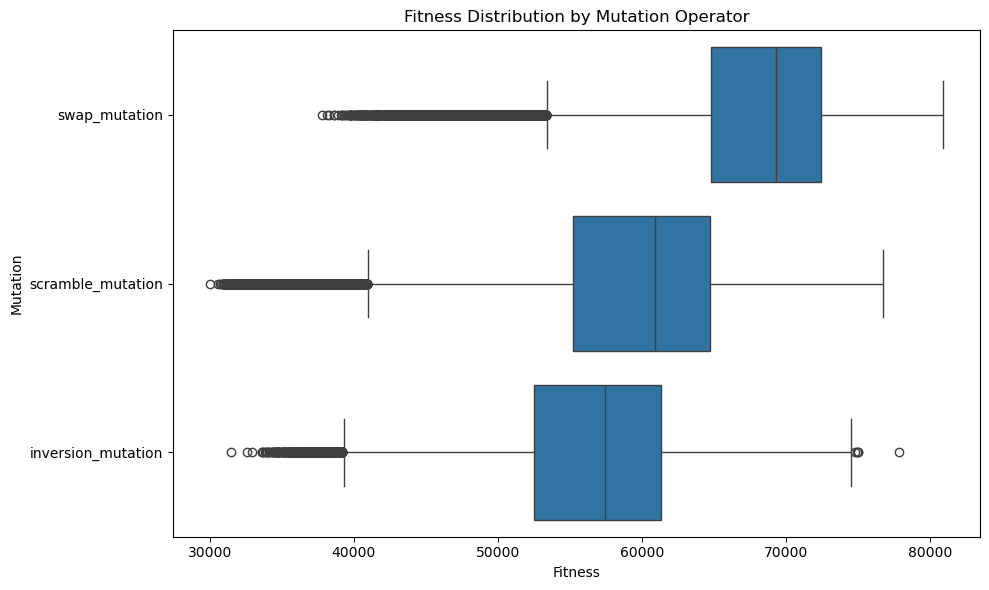

In [31]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    for fitness in fitness_list:
        records.append({
            "mutation": row["mutation"],
            "fitness": fitness
        })

df_expanded = pd.DataFrame(records)

mutation_order = (
    df_expanded.groupby("mutation")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_expanded, x="fitness", y="mutation", order=mutation_order)
plt.title("Fitness Distribution by Mutation Operator")
plt.xlabel("Fitness")
plt.ylabel("Mutation")
plt.tight_layout()
plt.show()

### Aggregate by crossover operator

> Aggregating by crossover operator shows that the partially mapped crossover might be slightly better than order crossover, but the difference doesn't seem to be significative

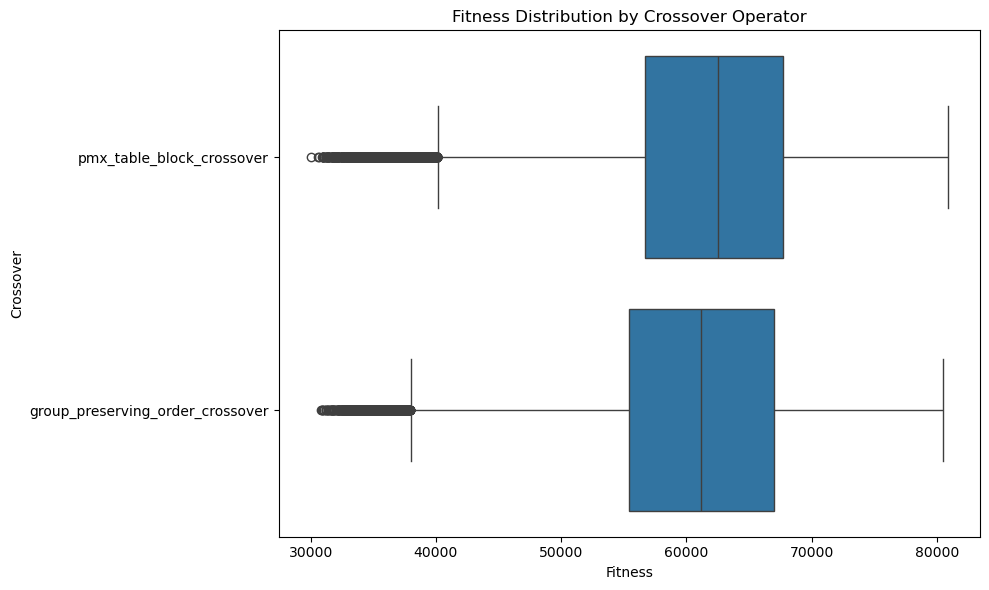

In [32]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    for fitness in fitness_list:
        records.append({
            "crossover": row["crossover"],
            "fitness": fitness
        })

df_expanded = pd.DataFrame(records)

mutation_order = (
    df_expanded.groupby("crossover")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_expanded, x="fitness", y="crossover", order=mutation_order)
plt.title("Fitness Distribution by Crossover Operator")
plt.xlabel("Fitness")
plt.ylabel("Crossover")
plt.tight_layout()
plt.show()


### Aggregate by mutation and mutation probability 

> Higher mutation probablities seem to be better than lower mutation probabilities, for all mutation operators, probably due to the fact that they introduce more diversity in the population including the best solutions. We can also see the scramble mutation is associated with the highest variation in fitness (highest IQR) probably reflecting the variation associated with the number of indexes to shuffle.


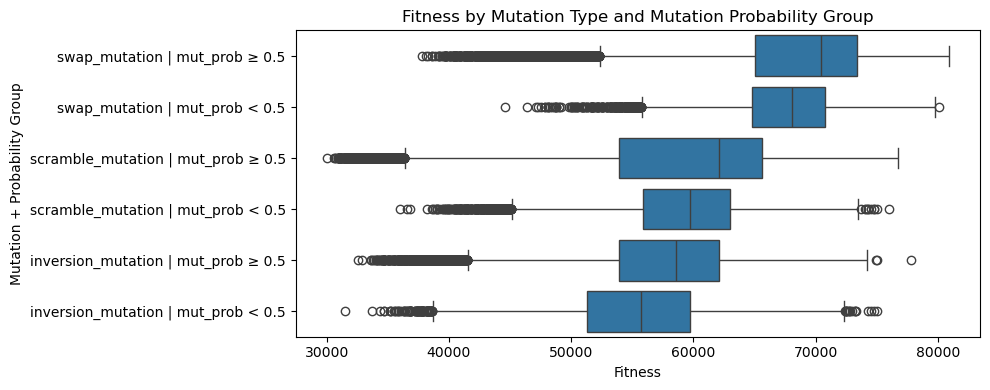

In [33]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    prob_label = "mut_prob ≥ 0.5" if row["mut_prob"] >= 0.5 else "mut_prob < 0.5"
    
    for fitness in fitness_list:
        records.append({
            "mutation": row["mutation"],
            "mut_prob_group": prob_label,
            "fitness": fitness
        })

df_expanded = pd.DataFrame(records)

df_expanded["group_label"] = df_expanded["mutation"] + " | " + df_expanded["mut_prob_group"]

label_order = (
    df_expanded.groupby("group_label")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, max(4, 0.5 * len(label_order))))
sns.boxplot(data=df_expanded, x="fitness", y="group_label", order=label_order)
plt.title("Fitness by Mutation Type and Mutation Probability Group")
plt.xlabel("Fitness")
plt.ylabel("Mutation + Probability Group")
plt.tight_layout()
plt.show()

### Aggregate by crossover and crossover probability

> Higher crossover probabilities also seem to be better than lower crossover probabilities, for all crossover operators, probably due to the fact that they also introduce more diversity.


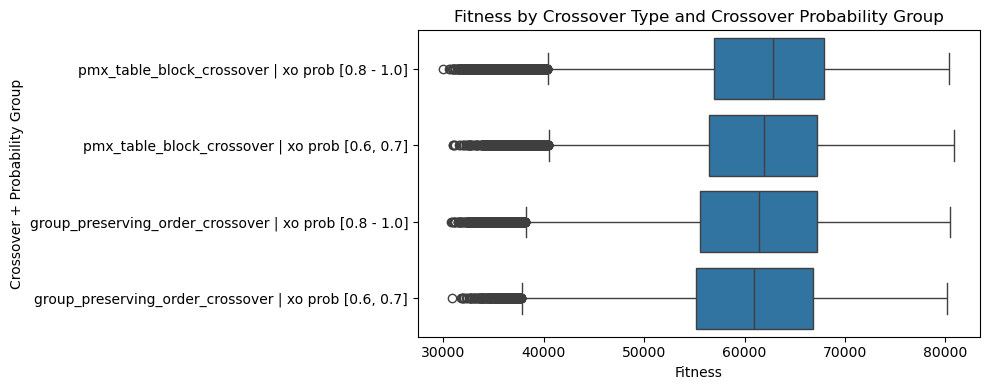

In [34]:
records = []

for _, row in df.iterrows():
    scores = json.loads(row["fitness_scores"])
    prob_label = "xo prob [0.8 - 1.0]" if row["xo_prob"] >= 0.8 else "xo prob [0.6, 0.7]"
    for score in scores:
        records.append({
            "crossover": row["crossover"],
            "xo_prob_group": prob_label,
            "fitness": score
        })
        
df_expanded = pd.DataFrame(records)

# Step 2: Create combined label: crossover | prob group
df_expanded["group_label"] = df_expanded["crossover"] + " | " + df_expanded["xo_prob_group"]

# Step 3: Sort by median fitness
label_order = (
    df_expanded.groupby("group_label")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Step 4: Plot
plt.figure(figsize=(10, max(4, 0.5 * len(label_order))))
sns.boxplot(data=df_expanded, x="fitness", y="group_label", order=label_order)
plt.title("Fitness by Crossover Type and Crossover Probability Group")
plt.xlabel("Fitness")
plt.ylabel("Crossover + Probability Group")
plt.tight_layout()
plt.show()


### Aggregate by selection

> Rank selection seems to be slightly better than tournament selection. 

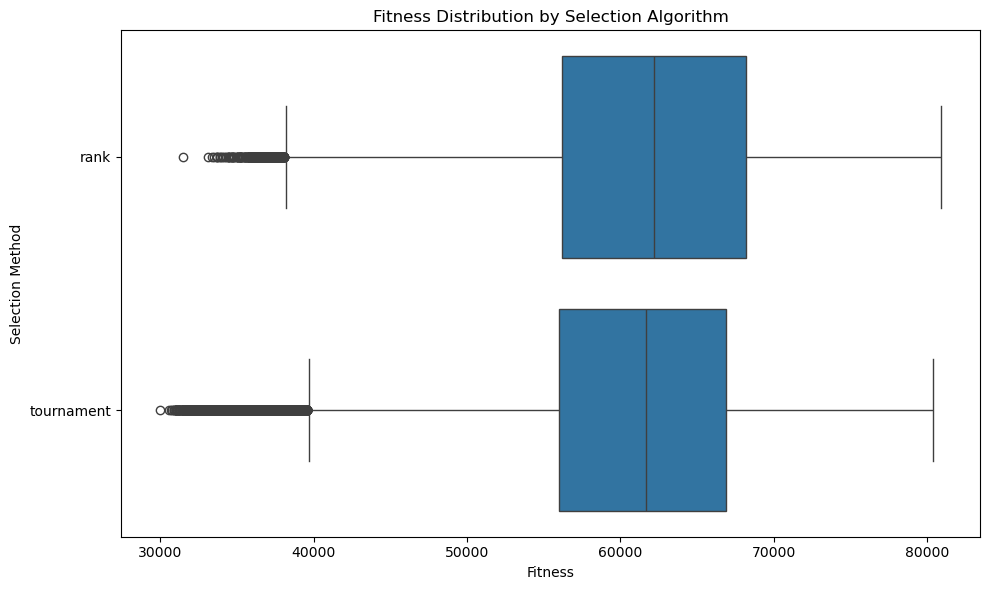

In [35]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    for fitness in fitness_list:
        records.append({
            "selection": row["selection"],
            "fitness": fitness
        })
        
df_expanded = pd.DataFrame(records)

selection_order = (df_expanded.groupby("selection")["fitness"].median().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_expanded, x="fitness", y="selection", order=selection_order)
plt.title("Fitness Distribution by Selection Algorithm")
plt.xlabel("Fitness")
plt.ylabel("Selection Method")
plt.tight_layout()
plt.show()

In [36]:
selection_summary = (
    df_expanded.groupby("selection")["fitness"]
               .agg(["count", "mean", "median", "std", "min", "max"])
               .sort_values("median")
               .round(3)
)
selection_summary


,count,mean,median,std,min,max
selection,,,,,,
tournament,90000,60758.181,61700.0,8708.478,30000.0,80400.0
rank,54000,61707.519,62200.0,8596.551,31500.0,80900.0


### Aggregate by selection and selection parameter

> However tournament selection with a tournament size of 15 seems to be slighly better than rank selection with exponential probability distribution for higher ranks. 
Higher torunament sizes (10, 10) are better than lower rank (5, 3) sizes, as the first reflect higher selection pressure (probability of selecting the best individuals). 
Higher factors for rank selection contribute to higher selection pressure (probability of selecting the best individuals) and therefore also show overall better performance. 

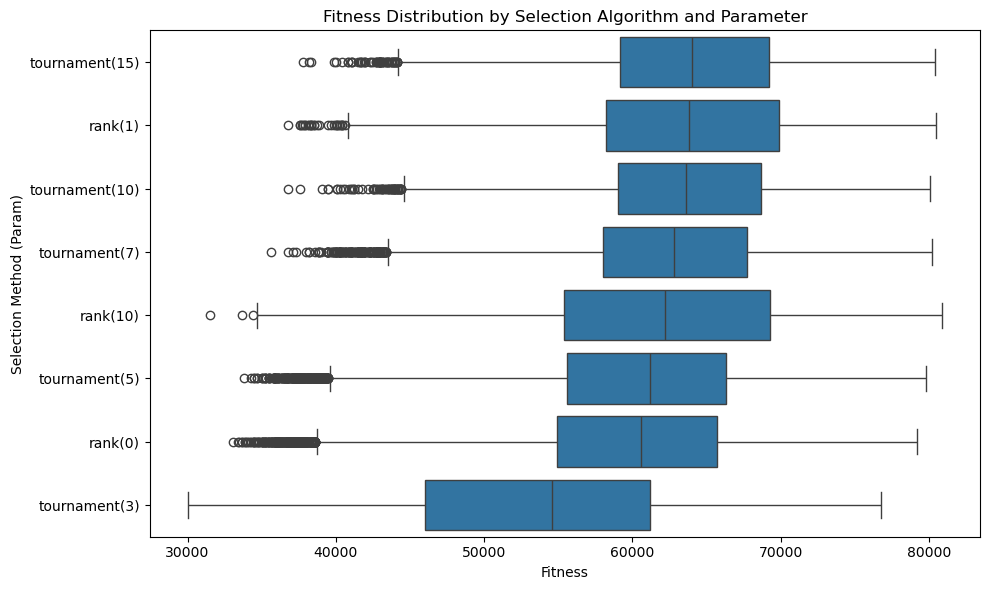

In [37]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    for fitness in fitness_list:
        records.append({
            "selection": row["selection"],
            "selection_param": row["selection_param"],
            "fitness": fitness
        })

df_expanded = pd.DataFrame(records)

# Step 2: Create a label like "tournament(5)" or "rank(1)"
df_expanded["selection_label"] = df_expanded.apply(
    lambda row: f"{row['selection']}({int(row['selection_param'])})", axis=1
)

# Step 3: Sort selection methods by median fitness (descending for maximization)
selection_order = (
    df_expanded.groupby("selection_label")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_expanded, x="fitness", y="selection_label", order=selection_order)
plt.title("Fitness Distribution by Selection Algorithm and Parameter")
plt.xlabel("Fitness")
plt.ylabel("Selection Method (Param)")
plt.tight_layout()
plt.show()


### Aggregate for elitism

> Elitism has a slightly positive impact on the performance of the algorithm.
The variance for the fitness is higher without elitism, reflecting the lower selection pressure in this case. 

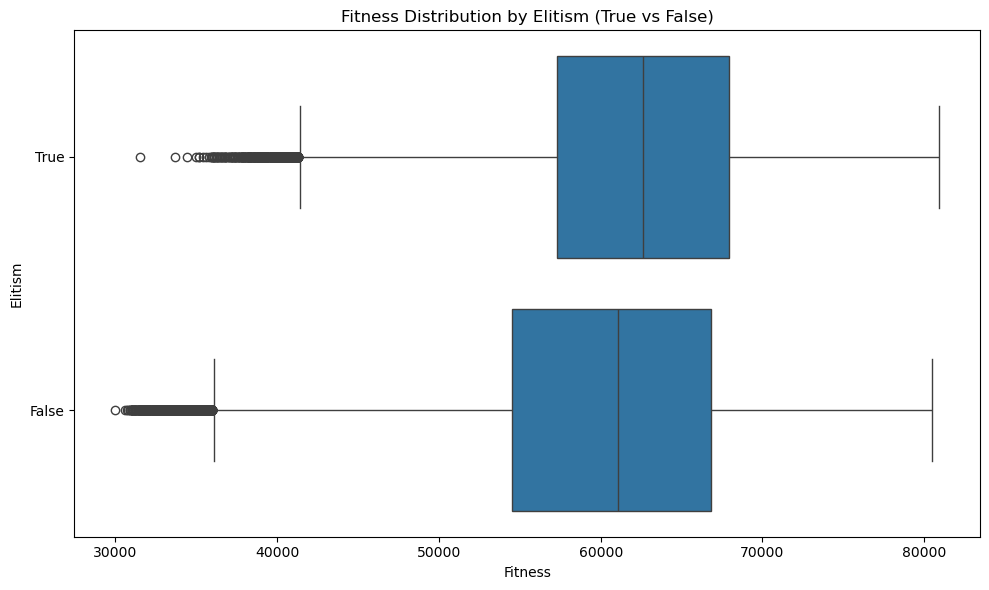

In [38]:
records = []

for _, row in df.iterrows():
    fitness_list = json.loads(row["fitness_scores"])
    for fitness in fitness_list:
        records.append({
            "elitism": row["elitism"], 
            "fitness": fitness
        })

df_expanded = pd.DataFrame(records)

df_expanded.groupby("elitism")["fitness"].median().sort_values(ascending=False)

elitism_order = (
    df_expanded.groupby("elitism")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

elitism_order = elitism_order.astype(str)

df_expanded["elitism"] = df_expanded["elitism"].astype(str)


plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_expanded, x="fitness", y="elitism", order=elitism_order)
plt.title("Fitness Distribution by Elitism (True vs False)")
plt.xlabel("Fitness")
plt.ylabel("Elitism")

for i, group in enumerate(elitism_order):
    group_data = df_expanded[df_expanded["elitism"] == group]["fitness"]
    q1 = group_data.quantile(0.25)
    q3 = group_data.quantile(0.75)
    median = group_data.median()
    iqr = q3 - q1

    # label = f"Median: {median:.0f} \nIQR: {iqr:.0f}"
    
    # ax.text(
    #     x=q3 + 400,   
    #     y=i - 0.1,    
    #     s=label,
    #     va='bottom',
    #     ha='left',
    #     fontsize=9,
    #     color="black"
    # )

plt.tight_layout()
plt.show()


## Fitness by generation plots

> We will plot only the top 10 configurations and the top configuration for each mutation, crossover and selection operator

In [39]:
results_file = "results/avg_fitness_by_generation.csv"

final_res = pd.read_csv(results_file)


final_res["fitness_per_generation"] = final_res["fitness_per_generation"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_per_generation"].apply(lambda x: x[-1])
final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)

final_res_sorted["final_best_fitness_prun"] = final_res_sorted["final_best_fitness_prun"].apply(json.loads)

> All top 10 configurations seem to have similar performance. <br>
Swap mutation is superior than the top configurations with scramble and inversion mutation.<br>
All top configurations have high mutation probability even for the most disrupting mutations (scramble and inversion).
High selection pressure dominate the top performing configurations (exponential rank and high tournament sizes (≥10)

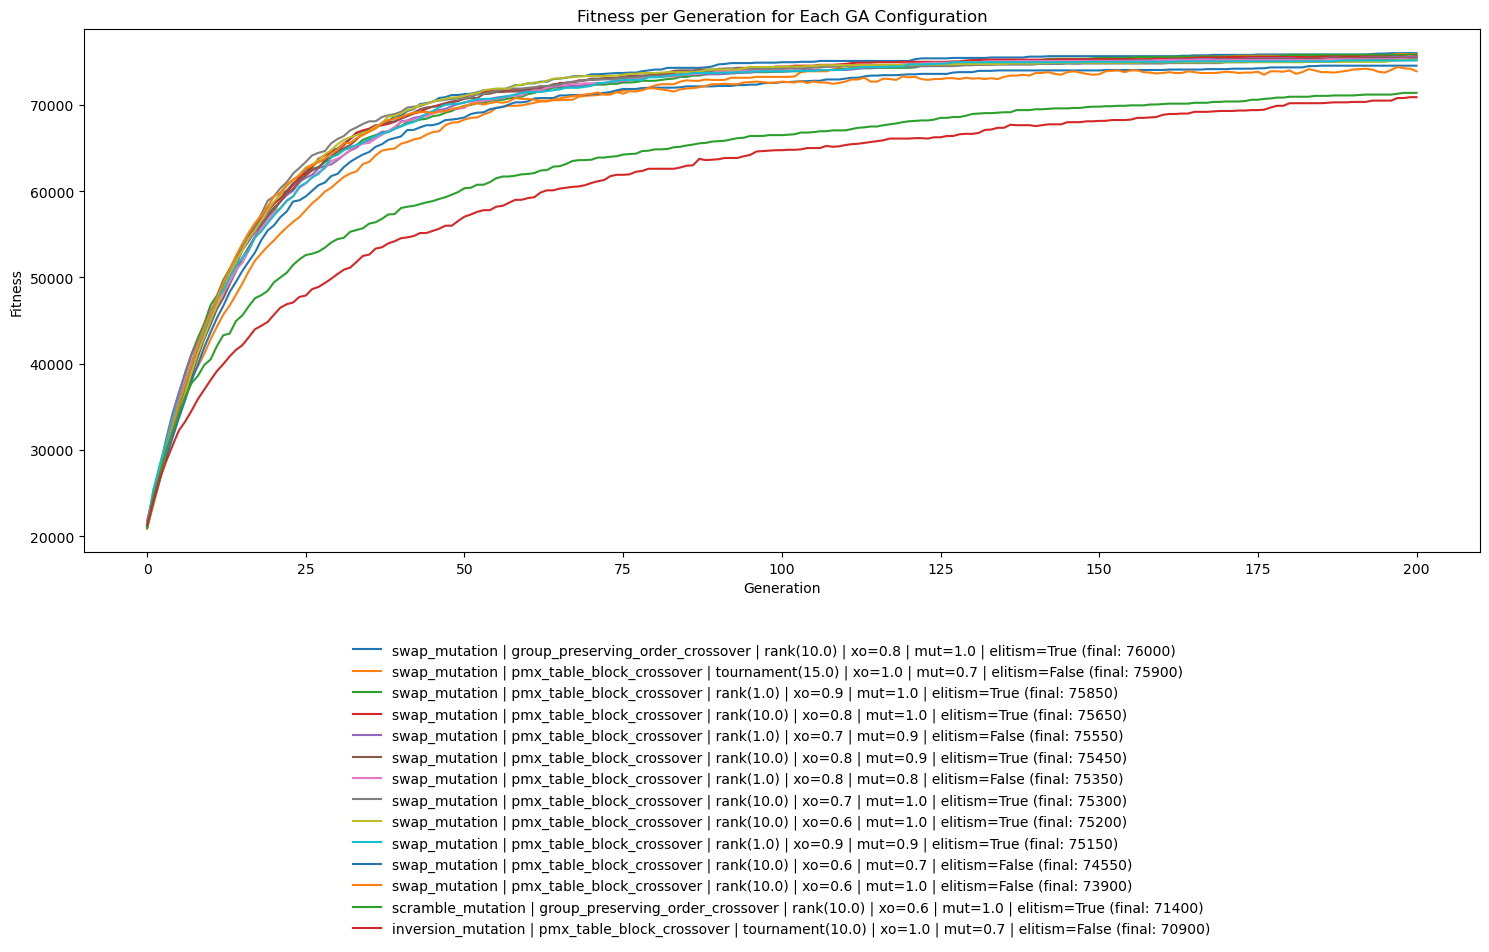

In [40]:

plt.figure(figsize=(15, 10))
for _, row in final_res_sorted.iterrows():
    fitness_curve = row["fitness_per_generation"]
    label = f"{row['configuration']} (final: {round(row['final_fitness'])})"
    plt.plot(fitness_curve, label=label)

# Customize plot
plt.title("Fitness per Generation for Each GA Configuration")
plt.xlabel("Generation")
plt.ylabel("Fitness")

# Legend at bottom, sorted by performance
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False)
plt.tight_layout()
plt.show()


In [41]:
all_scores = final_res_sorted['final_best_fitness_prun']

In [42]:
df_exploded = (
    final_res_sorted[["configuration", "final_best_fitness_prun"]]
    .explode("final_best_fitness_prun")
)
df_exploded

,configuration,final_best_fitness_prun
3,swap_mutation | group_preserving_order_crossov...,75800
3,swap_mutation | group_preserving_order_crossov...,74300
3,swap_mutation | group_preserving_order_crossov...,74300
3,swap_mutation | group_preserving_order_crossov...,78500
3,swap_mutation | group_preserving_order_crossov...,75100
...,...,...
0,inversion_mutation | pmx_table_block_crossover...,66600
0,inversion_mutation | pmx_table_block_crossover...,67500
0,inversion_mutation | pmx_table_block_crossover...,73700
0,inversion_mutation | pmx_table_block_crossover...,74800


In [43]:
df_exploded["final_best_fitness_prun"] = pd.to_numeric(
    df_exploded["final_best_fitness_prun"], errors="coerce"
)

summary = (
    df_exploded
    .groupby("configuration")["final_best_fitness_prun"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(3)
    .sort_values("median")
)

summary


,count,mean,median,std,min,max
configuration,,,,,,
inversion_mutation | pmx_table_block_crossover | tournament(10.0) | xo=1.0 | mut=0.7 | elitism=False,100,70827.0,71050.0,2592.641,64800,77600
scramble_mutation | group_preserving_order_crossover | rank(10.0) | xo=0.6 | mut=1.0 | elitism=True,100,71682.0,71400.0,2429.174,65900,76900
swap_mutation | pmx_table_block_crossover | rank(10.0) | xo=0.6 | mut=0.7 | elitism=False,100,74439.0,74550.0,2485.184,68200,80300
swap_mutation | pmx_table_block_crossover | rank(1.0) | xo=0.9 | mut=0.9 | elitism=True,100,75367.0,75150.0,2820.132,67000,80300
swap_mutation | pmx_table_block_crossover | rank(10.0) | xo=0.6 | mut=1.0 | elitism=True,100,75213.0,75200.0,2330.980,67100,79200
swap_mutation | pmx_table_block_crossover | rank(10.0) | xo=0.7 | mut=1.0 | elitism=True,100,75121.0,75300.0,2319.365,67800,80900
swap_mutation | pmx_table_block_crossover | rank(1.0) | xo=0.8 | mut=0.8 | elitism=False,100,75057.0,75350.0,2540.987,68000,81400
swap_mutation | pmx_table_block_crossover | rank(10.0) | xo=0.8 | mut=0.9 | elitism=True,100,75405.0,75450.0,2309.286,68500,80300
swap_mutation | pmx_table_block_crossover | rank(1.0) | xo=0.7 | mut=0.9 | elitism=False,100,75256.0,75600.0,2345.179,67500,80700


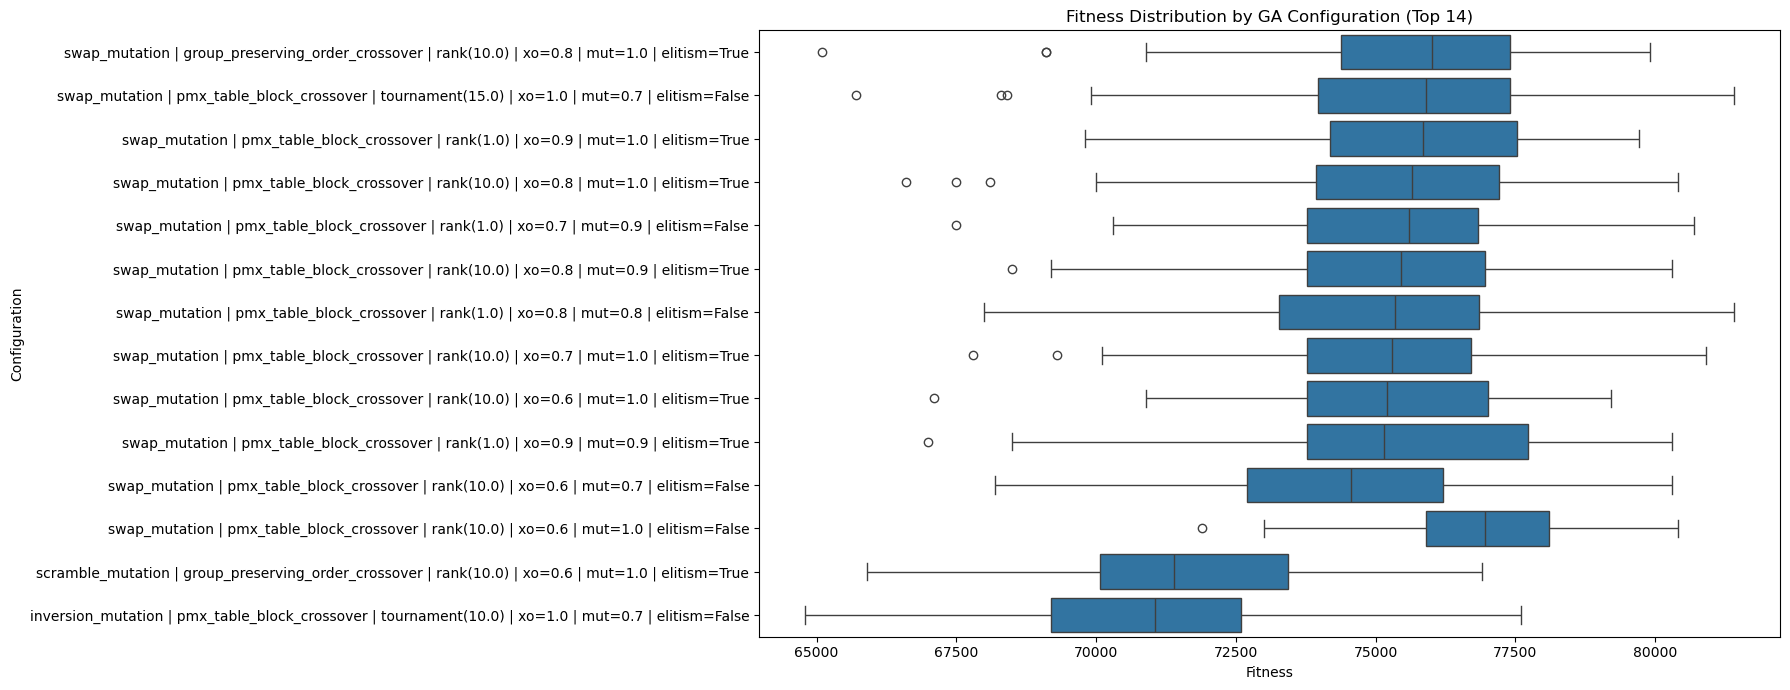

In [44]:
plt.figure(figsize=(18, 7))  

ax = sns.boxplot(data=df_exploded, x="final_best_fitness_prun", y="configuration")

plt.title("Fitness Distribution by GA Configuration (Top 14)")
plt.xlabel("Fitness")
plt.ylabel("Configuration")

config_order = df_exploded["configuration"].unique()

for i, config in enumerate(config_order):
    group_data = df_exploded[df_exploded["configuration"] == config]["final_best_fitness_prun"]
    q1 = group_data.quantile(0.25)
    q3 = group_data.quantile(0.75)
    median = group_data.median()
    iqr = q3 - q1

plt.tight_layout()
plt.show()


### Plot the top 3 configurations

> From the top 3 configurations, the ones with elitism (green and blue lines) seem to converge faster to a better solution than the one without elitism (orange line), around 100 generations.
<br>A tournament selection with high selection pressure (k=15) and without elitism (orange line) are probably related to higher diversity in the population, which may acount to a positive effect in the last generations refleted in the positive slope of the fitness curve in these last generations.   

In [45]:
outlier=final_res_sorted.iloc[11]
outlier.configuration

'swap_mutation | pmx_table_block_crossover | rank(10.0) | xo=0.6 | mut=1.0 | elitism=False'

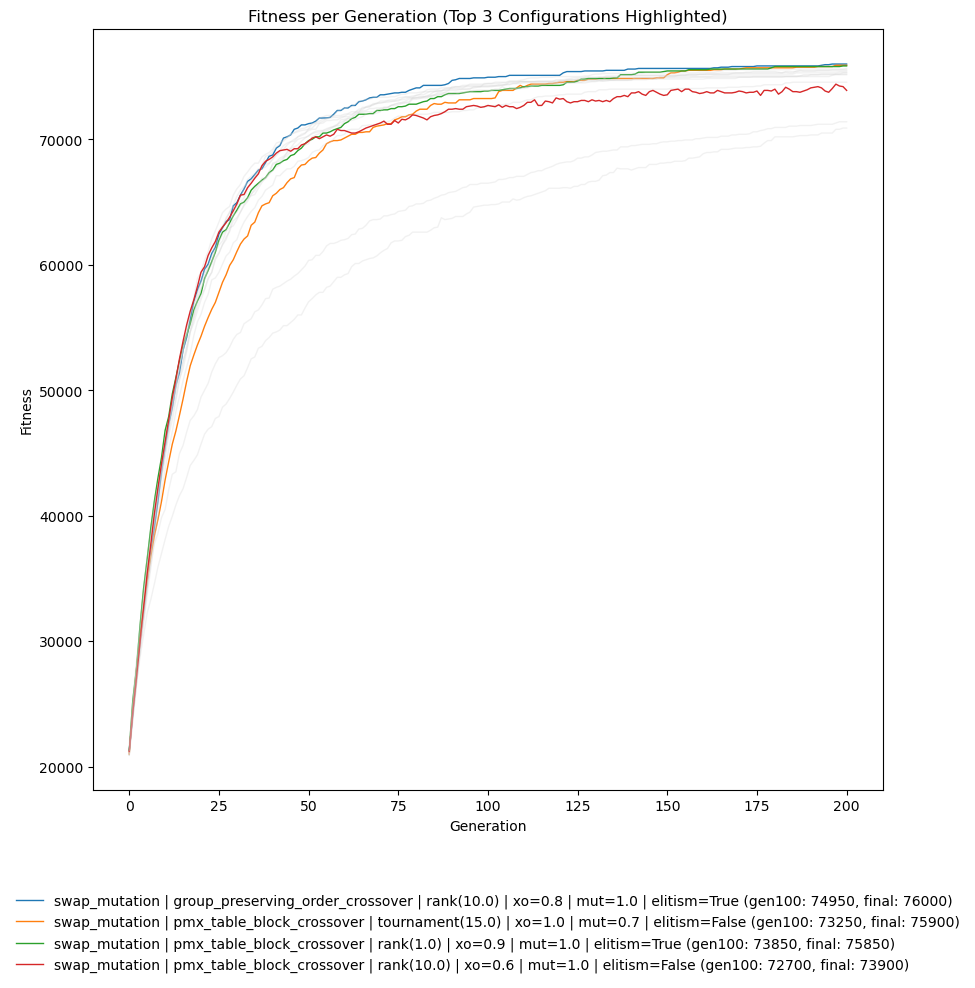

In [46]:
top_3 = final_res_sorted.head(3)
top_configs = top_3["configuration"].tolist()
top_configs.append(outlier.configuration)

plt.figure(figsize=(10, 10))

for _, row in final_res_sorted.iterrows():
    fitness_curve = row["fitness_per_generation"]
    config = row["configuration"]
    gen100_median = fitness_curve[100]
    label = f"{row['configuration']} (gen100: {round(gen100_median)}, final: {round(row['final_fitness'])})"

    if config in top_configs:
        plt.plot(fitness_curve, label=label, linewidth=1)
    else:
        plt.plot(fitness_curve, color="lightgray", linewidth=1, alpha=0.3)

plt.title("Fitness per Generation (Top 3 Configurations Highlighted)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)
plt.tight_layout()
plt.show()



In [47]:
df_exploded = (
    top_3[["configuration", "final_best_fitness_prun"]]
    .explode("final_best_fitness_prun")
)
df_exploded["final_best_fitness_prun"] = pd.to_numeric(
    df_exploded["final_best_fitness_prun"], errors="coerce"
)

summary = (
    df_exploded
    .groupby("configuration")["final_best_fitness_prun"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(3)
    .sort_values("median")
)

summary


,count,mean,median,std,min,max
configuration,,,,,,
swap_mutation | pmx_table_block_crossover | rank(1.0) | xo=0.9 | mut=1.0 | elitism=True,100,75796.0,75850.0,2101.174,69800,79700
swap_mutation | pmx_table_block_crossover | tournament(15.0) | xo=1.0 | mut=0.7 | elitism=False,100,75573.0,75900.0,2841.000,65700,81400
swap_mutation | group_preserving_order_crossover | rank(10.0) | xo=0.8 | mut=1.0 | elitism=True,100,75701.0,76000.0,2424.100,65100,79900


In [48]:
top_3_groups = [
    grp["final_best_fitness_prun"].values
    for _, grp in df_exploded.groupby("configuration", sort=False)
]

kruskal_wallis_test(top_3_groups)

Kruskal-Wallis H-test statistic: 0.145
P-value: 9.299e-01
Eta-squared effect size (η²): -0.006
----------------------------------------------------------------------------------------------------
FAIL TO REJECT H0: No significant differences.


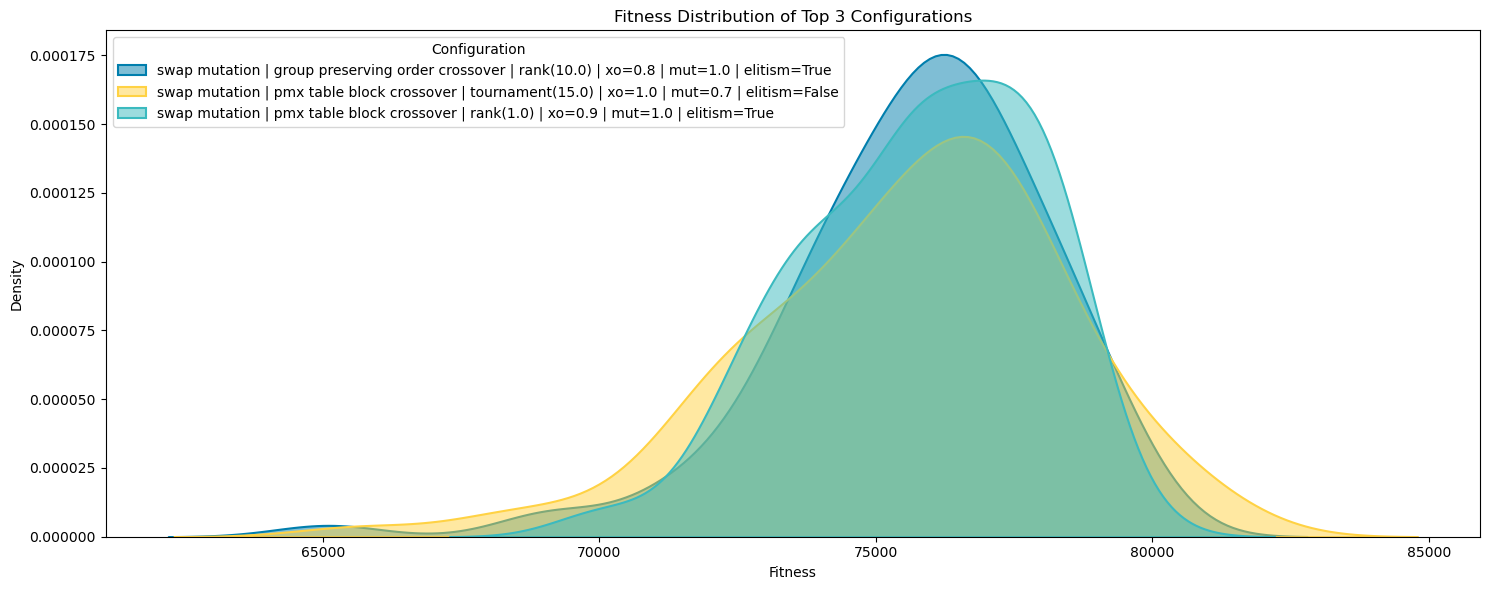

In [49]:
palette = {'swap_mutation | group_preserving_order_crossover | rank(10.0) | xo=0.8 | mut=1.0 | elitism=True': "#007ead",
            'swap_mutation | pmx_table_block_crossover | tournament(15.0) | xo=1.0 | mut=0.7 | elitism=False':"#ffd244",
           'swap_mutation | pmx_table_block_crossover | rank(1.0) | xo=0.9 | mut=1.0 | elitism=True': "#3bbabf"}

plot_fitness_distribution(
    df=df_exploded,
    column="configuration",
    palette=palette,
    title="Fitness Distribution of Top 3 Configurations",
    figsize=(15,6),
    x='final_best_fitness_prun'
)


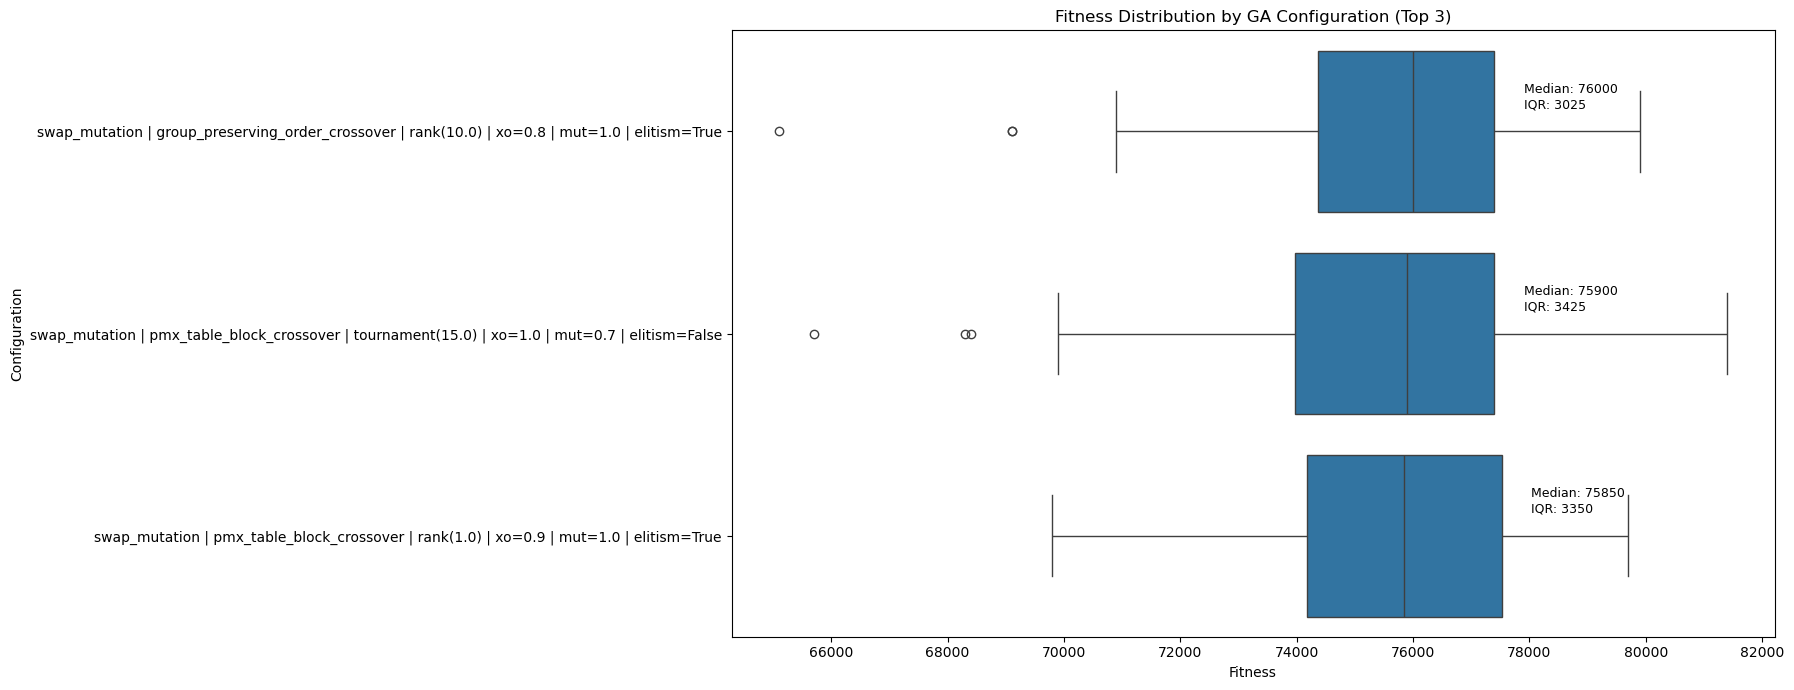

In [50]:
plt.figure(figsize=(18, 7))  

ax = sns.boxplot(data=df_exploded, x="final_best_fitness_prun", y="configuration")

plt.title("Fitness Distribution by GA Configuration (Top 3)")
plt.xlabel("Fitness")
plt.ylabel("Configuration")

config_order = df_exploded["configuration"].unique()

for i, config in enumerate(config_order):
    group_data = df_exploded[df_exploded["configuration"] == config]["final_best_fitness_prun"]
    q1 = group_data.quantile(0.25)
    q3 = group_data.quantile(0.75)
    median = group_data.median()
    iqr = q3 - q1

    label = f"Median: {median:.0f} \nIQR: {iqr:.0f}"
    
    ax.text(
        x=q3 + 500, 
        y=i - 0.1,  
        s=label,
        va='bottom',
        ha='left',
        fontsize=9,
        color="black"
    )

plt.tight_layout()
plt.show()
